In [31]:
from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pathlib import Path
from data import load_iq

def imshow(im):
    from skimage.exposure import exposure
    p2, p98 = np.percentile(im, (2, 98))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
    
def snr(pure, noisy):
    sig_pow = np.mean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.mean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Config

In [3]:
fft_points = 1024 * 8
freq_axis_avg_decimation = 64
sims = ['MODEL', 'PYHA']

# Prepare input

In [90]:
# orig_inp = load_iq('/home/gaspar/git/pyhacores/data/f2404_fs16.896_one_hop.iq')
orig_inp = load_iq('/home/gaspar/git/m037_tests/data/Phantom 3 & 4=-90_20180104123014261769/1515061814.9318_qdetector_fs=20000000.0_bw=20000000.0_fc=2420000000.0_d=0.raw')
# orig_inp = orig_inp.imag
# orig_inp = signal.decimate(orig_inp, 8)
# orig_inp *= 0.5

# n = np.random.uniform(-1, 1, len(orig_inp)) + np.random.uniform(-1, 1, len(orig_inp))*1j
# n *= 0.9
# orig_inp += n

# make sure input divides with fft_points
orig_inp = np.array(orig_inp[:int(len(orig_inp) // fft_points) * fft_points])

6.103515625e-05 0.0001


/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


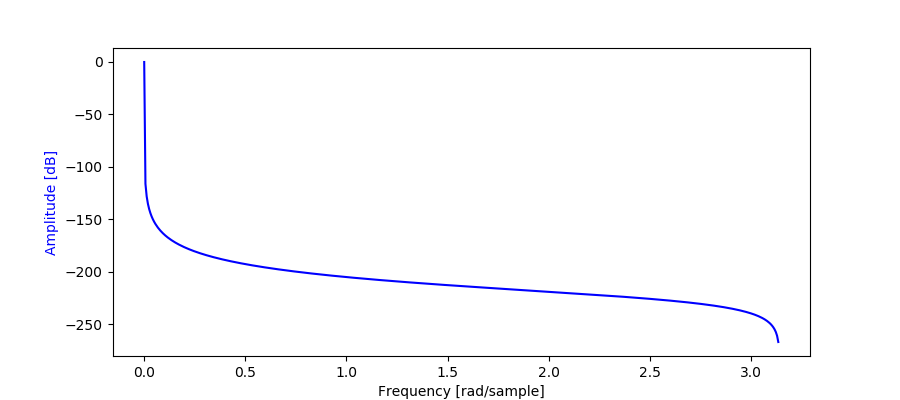

<IPython.core.display.Javascript object>


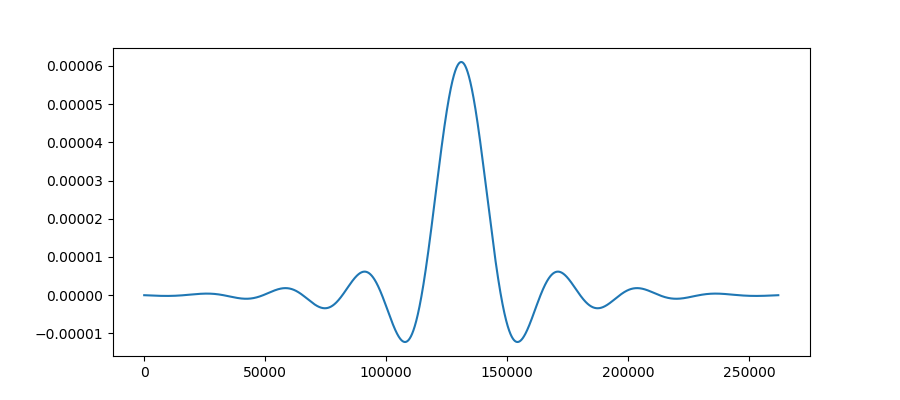

-1.462926843022371e-11


In [99]:
# base = 0.5 / fft_points / 2
base = 1.0 / fft_points / 2

print(base, 0.0001)
overlap = 32
taps = signal.firwin2(fft_points * overlap, [0, base, base, 1.0], [1, 1, 0, 0])
# taps = signal.remez(fft_points * overlap, [0, base, base+0.000000001, 0.5], [1, 0], maxiter=20)

# taps /= taps.max()
w, h = signal.freqz(taps)

plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
plt.show()

plt.plot(taps)
plt.show()
print(taps[0])

In [ ]:
f = np.fft.fft(taps)

In [ ]:
a = 20 * np.log10(abs(f))
a = np.fft.fftshift(a)
plt.plot(a)
plt.show()

In [ ]:
import scipy.signal
inp = [0.0 + 0.0j] * fft_points * overlap
inp[0] = 1.0 + 1.0j

fir = scipy.signal.lfilter(taps, [1.0], inp)


In [ ]:
plt.magnitude_spectrum(fir, window=matplotlib.mlab.window_none, scale='dB')

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
plt.grid()
plt.show()

# TROLOLOLO

In [100]:
step = fft_points // overlap
chunks = []
for i in range(0, len(orig_inp) - fft_points, step):
    new = np.array(orig_inp[i: i+fft_points])
    chunks.append(new)
chunks = np.array(chunks)
print(chunks, chunks.shape)

[[ 0.00025057-4.7741644e-04j  0.00025057-4.7741644e-04j
   0.00025057-4.7741644e-04j ... -0.00023772+1.0864809e-05j
  -0.00023772-4.7741644e-04j  0.00025057+1.0864809e-05j]
 [ 0.00025057+4.9914606e-04j  0.00073885+1.4757086e-03j
  -0.00023772+4.9914606e-04j ...  0.00025057+4.9914606e-04j
   0.00025057+4.9914606e-04j  0.00122713+1.0864809e-05j]
 [ 0.00122713-4.7741644e-04j  0.00025057+1.4757086e-03j
   0.00025057-4.7741644e-04j ...  0.00073885+4.9914606e-04j
  -0.00023772-4.7741644e-04j  0.00122713+1.0864809e-05j]
 ...
 [ 0.00025057+1.0864809e-05j -0.00023772+1.4757086e-03j
   0.00025057+4.9914606e-04j ... -0.00023772+1.0864809e-05j
   0.00025057+1.0864809e-05j -0.00023772+1.0864809e-05j]
 [ 0.00073885+4.9914606e-04j  0.00073885+1.0864809e-05j
   0.00025057+1.0864809e-05j ...  0.00025057-4.7741644e-04j
   0.00025057+4.9914606e-04j -0.00023772-1.4539789e-03j]
 [-0.00023772+1.0864809e-05j  0.00025057+1.0864809e-05j
  -0.00121428+1.9639898e-03j ...  0.00171541+4.9914606e-04j
  -0.00023772+

In [92]:
window = np.resize(chunks, (-1, len(taps)))
window *= taps
# window *= np.hanning(len(taps))
print(window.shape)
chunks = np.resize(window, (31104, 8192))
print(chunks.shape)

(242, 1048576)
(31104, 8192)


In [93]:
chunks = np.resize(chunks, (len(chunks)//overlap, overlap, fft_points))
print(chunks.shape)

(243, 128, 8192)


In [94]:
sums = np.mean(chunks, axis=1)
print(sums.shape)

(243, 8192)


/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


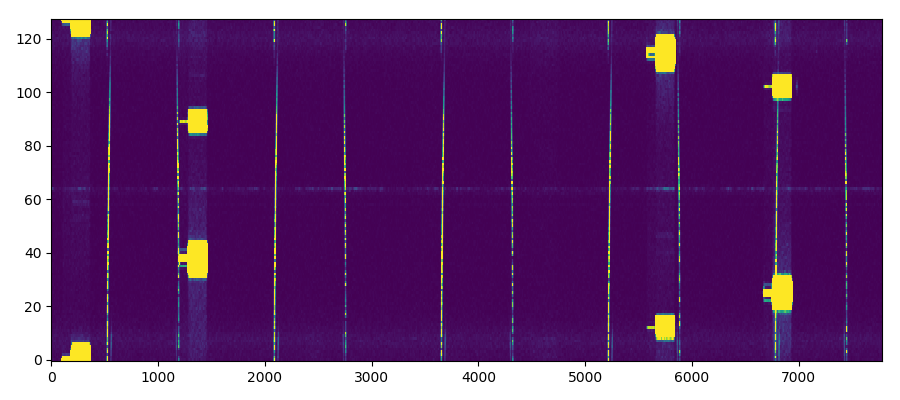

In [103]:
# take fft, this also fixes ordering
chunks *= np.hanning(fft_points)
ffts = np.fft.fft(chunks).T

# take magnitude
mag = np.conjugate(ffts) * ffts
mag = mag.real

# # fftshift
spectro_out = np.roll(mag, fft_points//2, axis=0)

# avg decimation
x = np.split(spectro_out, len(spectro_out) // freq_axis_avg_decimation)
golden_output = np.average(x, axis=1)

imshow(golden_output)

# Golden output

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


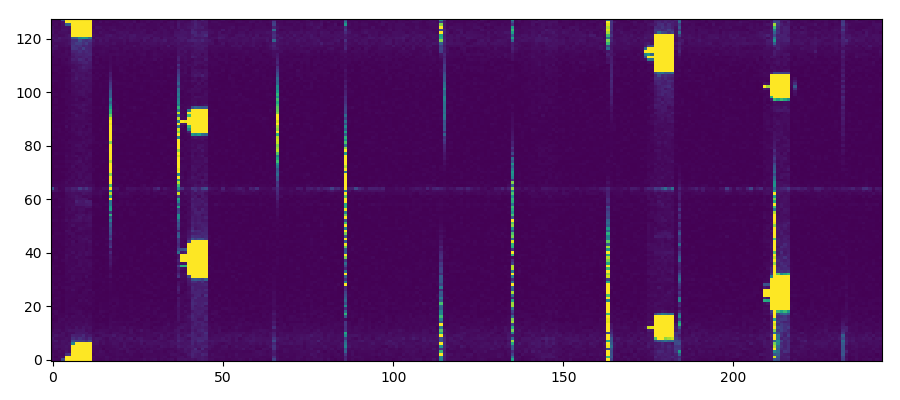

In [96]:
_, _, spectro_out = signal.spectrogram(orig_inp, 1, nperseg=fft_points, return_onesided=False, detrend=False,
                               noverlap=0.5, window='hann')

# fftshift
spectro_out = np.roll(spectro_out, fft_points//2, axis=0)

# avg decimation
x = np.split(spectro_out, len(spectro_out) // freq_axis_avg_decimation)
golden_output = np.average(x, axis=1)

imshow(golden_output)

# MANUAL

In [ ]:
# divide to chunks of size 'nfft'
chunks = np.split(orig_inp, len(orig_inp) // fft_points)

# apply window
windowed = chunks * np.hanning(fft_points)

# take fft, this also fixes ordering
ffts = np.fft.fft(windowed).T

# take magnitude
mag = np.conjugate(ffts) * ffts
mag = mag.real

# # fftshift
spectro_out = np.roll(mag, fft_points//2, axis=0)

# avg decimation
x = np.split(spectro_out, len(spectro_out) // freq_axis_avg_decimation)
golden_output = np.average(x, axis=1)

imshow(golden_output)
# imshow(mag)

# MANUAL PRESUM

In [ ]:
# divide to chunks of size 'nfft'
chunks = np.array(np.split(orig_inp, len(orig_inp) // fft_points))

# apply window
# windowed = chunks * np.hanning(fft_points)
windowed = chunks * taps
# windowed = chunks

print(windowed.shape)
# presum

presum = []
for row in windowed:
#     print(row.shape)
    x = np.array(np.split(row, freq_axis_avg_decimation))
#     print(x.shape)
    golden_output = np.sum(x, axis=0)
#     print(golden_output.shape)
    presum.append(golden_output)
    # print(golden_output)
#     windowed = golden_output
presum = np.array(presum)
# take fft, this also fixes ordering
ffts = np.fft.fft(presum).T

# take magnitude
mag = np.conjugate(ffts) * ffts
mag = mag.real

# fftshift
spectro_out = np.roll(mag, fft_points//2// freq_axis_avg_decimation, axis=0)

# # avg decimation
# x = np.split(spectro_out, len(spectro_out) // freq_axis_avg_decimation)
# golden_output = np.average(x, axis=1)

imshow(spectro_out)

In [ ]:
# divide to chunks of size 'nfft'
chunks = orig_inp[10*fft_points: 11*fft_points]

# apply window
windowed = chunks * np.hanning(fft_points)
# windowed = chunks
# print(windowed.shape)

# take fft, this also fixes ordering
ffts = np.fft.fft(windowed)

# take magnitude
mag = np.conjugate(ffts) * ffts
mag = mag.real

# # fftshift
spectro_out = np.roll(mag, fft_points//2, axis=0)

# avg decimation
# golden_output = spectro_out
x = np.split(spectro_out, len(spectro_out) // freq_axis_avg_decimation)
golden_output = np.average(x, axis=1)

plt.plot(golden_output)
plt.show()
# imshow(mag)

In [ ]:
0.5 / 256

In [ ]:
# divide to chunks of size 'nfft'
chunks = orig_inp[10*fft_points: 11*fft_points]

# apply window
# windowed = chunks * np.hanning(fft_points)
plt.plot(taps)
plt.show()
windowed = chunks * taps
# windowed = np.array(chunks)


# presum
# x = np.array(np.split(windowed, 2))
# golden_output = np.average(x, axis=0)
# windowed = golden_output

windowed = windowed[:fft_points//2] + windowed[fft_points//2:]

# take fft, this also fixes ordering
ffts = np.fft.fft(windowed)

# take magnitude
mag = np.conjugate(ffts) * ffts
mag = mag.real

# fftshift
spectro_out = np.roll(mag, fft_points//2//2, axis=0)

# # avg decimation
# x = np.split(spectro_out, len(spectro_out) // freq_axis_avg_decimation)
# golden_output = np.average(x, axis=1)

plt.plot(spectro_out)
plt.show()

# imshow(mag)

In [ ]:
l = [0.0] * 10 + [1.0] * 10 + [0.0] * 10
plt.plot(l)
plt.show()

iff = np.fft.ifft(l)

plt.plot(abs(iff))
plt.show()

In [ ]:
MAKSA ARVE!!!

# Packager

In [ ]:
dut = Packager(fft_points)
sims = simulate(dut, orig_inp, output_callback=DataWithIndex._pyha_unpack, simulations=sims)
assert sims_close(sims)

In [ ]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

# Apply windowing

In [ ]:
dut = Windower(fft_points)

In [ ]:
inp = np.array(sims['PYHA'])
sims = simulate(dut, inp, simulations=sims, output_callback=DataWithIndex._pyha_unpack, input_callback=DataWithIndex._pyha_pack)
assert hardware_sims_equal(sims)

In [ ]:
plt.plot(np.hstack(sims['MODEL']).real, label='MODEL')
plt.plot(np.hstack(sims['PYHA']).real, label='HARDWARE')
plt.legend()
plt.show()

In [ ]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

# FFT

In [ ]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = R2SDF(fft_points)
sims = simulate(dut, inp, simulations=sims, output_callback=DataWithIndex._pyha_unpack, input_callback=DataWithIndex._pyha_pack)
assert hardware_sims_equal(sims)

In [ ]:
plt.plot(np.hstack(sims['MODEL']).real, label='MODEL')
plt.plot(np.hstack(sims['PYHA']).real, label='HARDWARE')
plt.legend()
plt.show()

In [ ]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

# Bit-reversal and fftshift

In [ ]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = BitReversal(fft_points)
sims = simulate(dut, inp, simulations=sims, output_callback=DataWithIndex._pyha_unpack, input_callback=DataWithIndex._pyha_pack)
assert hardware_sims_equal(sims)


In [ ]:
plt.plot(np.hstack(sims['MODEL']).real, label='MODEL')
plt.plot(np.hstack(sims['PYHA']).real, label='HARDWARE')
plt.legend()
plt.show()

In [ ]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

# Magnitude

In [ ]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = ConjMult()
sims = simulate(dut, inp, simulations=sims, output_callback=DataWithIndex._pyha_unpack, input_callback=DataWithIndex._pyha_pack)
assert hardware_sims_equal(sims)

In [ ]:
plt.plot(np.hstack(sims['MODEL']).real, label='MODEL')
plt.plot(np.hstack(sims['PYHA']).real, label='HARDWARE')
plt.legend()
plt.show()

In [ ]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

# Decimation AVG

In [ ]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = AvgDecimate(freq_axis_avg_decimation)
sims = simulate(dut, inp, simulations=sims, output_callback=DataWithIndex._pyha_unpack, input_callback=DataWithIndex._pyha_pack)
assert hardware_sims_equal(sims)

In [ ]:
plt.plot(np.hstack(sims['MODEL']).real, label='MODEL')
plt.plot(np.hstack(sims['PYHA']).real, label='HARDWARE')
plt.legend()
plt.show()

In [ ]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

# Merged object

In [ ]:
inp = orig_inp
dut = Spectrogram(fft_points, decimate_by=freq_axis_avg_decimation)
full_sims = simulate(dut, inp, simulations=sims, output_callback=DataWithIndex._pyha_unpack)
assert hardware_sims_equal(sims)

In [ ]:
x = np.array(full_sims['PYHA']).T
imshow(x)

# Final evaluation

In [ ]:
x = np.array(sims['PYHA']).T
imshow(x)

In [ ]:
imshow(golden_output)

In [ ]:
flat_spectro = golden_output.flatten()
flat_spectro /= golden_output.max()

flat_pyha = x.flatten()
flat_pyha /= flat_pyha.max()

plt.plot(flat_spectro, label='MODEL_PYHA')
plt.plot(flat_pyha, label='HARDWARE')
plt.legend()
plt.show()

plt.plot(flat_pyha - flat_spectro, label='MODEL_PYHA')
plt.legend()
plt.show()

snrs = snr(flat_spectro, flat_pyha)
print(f'Block AVG SNR: {snrs}')
